```Name: Wong Wen Bing```    
```Admin #: 230436M```  
```PEM GROUP: AA2303```

# About Objective: Classifying Birds
This is a series of jupyter notebooks aimed at using Python in conducting text classification in predicting the type of birds. 

In the dataset provided, there are 2 columns: description and species (4 species). This is hence a supervised learning problem due to the presence of labelled data.


# **Part 1: Data Preparation and Understanding (1/3)** 
This part will comprise of the data understanding, data pre-processing through the cleaning the textual data. 

Installing Necessary Libraries and Importing them into the dataset

In [4]:
# pip install pandas seaborn nltk matplotlib openpyxl

In [5]:
# Import 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import numpy as np
import pickle
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer 
from nltk.corpus import stopwords #stopwords
from nltk.stem.wordnet import WordNetLemmatizer #lemmatization

In [6]:
# nltk.download('all')

## **Section A: Reading in data and understanding data**   
This section will briefly cover the reading and understanding of the dataset that is given currently

In [8]:
data=pd.read_excel('Data.xlsx')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  718 non-null    object
 1   species      742 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [10]:
data.head()

,description,species
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna
1,Click here for more information about the Red ...,Collared Kingfisher
2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole
3,"Search from thousands of royalty-free ""Javan M...",Javan Myna
4,521 foreground recordings and 156 background ...,Little Egret


In [11]:
data.shape

(742, 2)

On initial examination of the dataset, we can observe that there are 2 columns, with a total of 742 rows. <br> 
<br> 
The column 'description' has braackets quotations and some special characters which probably needs to be removed. We can also observe that the species is the target variable.

In [13]:
data['species'].unique()

array(['Javan Myna', 'Collared Kingfisher', 'Black-naped Oriole',
       'Little Egret'], dtype=object)

We can now infer that this classification is probably going to be a multi-class classification due to the presence of more than 2 types of species of birds. 

**Checking for null and duplicates**  
- there might be some empty values or duplicate values that we need to check for

In [16]:
data.isna().sum()

description    24
species         0
dtype: int64

In [17]:
dup=data.duplicated().value_counts()
print(f'''
duplicates: {dup[True]}
''')


duplicates: 128



From the above output we can infer the below: 
- there are 24 null values
- there are 128 duplicates

#### **Removing null and duplicate values** 
- To ensure data integrity, null and duplicate values are removed first before conducting any further preprocess and understanding of the dataset.

In [19]:
#drop null and duplicate values
data=data.dropna()
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611 entries, 0 to 739
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  611 non-null    object
 1   species      611 non-null    object
dtypes: object(2)
memory usage: 14.3+ KB


## **Section B: Data Understanding** 
- To understand the distribution of data, I set out to do some visualisations to visualise the distribution of the dataset.

Firstly, we did a distribution of the species (the target variable in the dataset.)

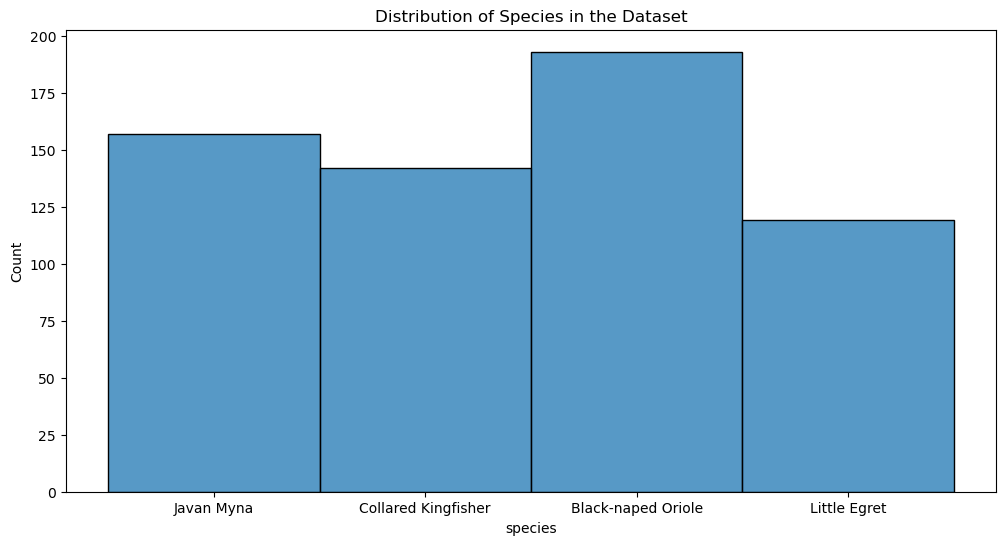

In [21]:
group=data.groupby(['species']).count()
plt.figure(figsize=(12, 6))  
sns.histplot(data['species'])
plt.title('Distribution of Species in the Dataset')
plt.show()

As we can see from above, we can realise that the Black-napled Oriole has the most records in the dataset. 
This means that there is an inbalance in the dataset, which needs to be taken note of. 

Now, we are going to investigate the average length of description in the dataset

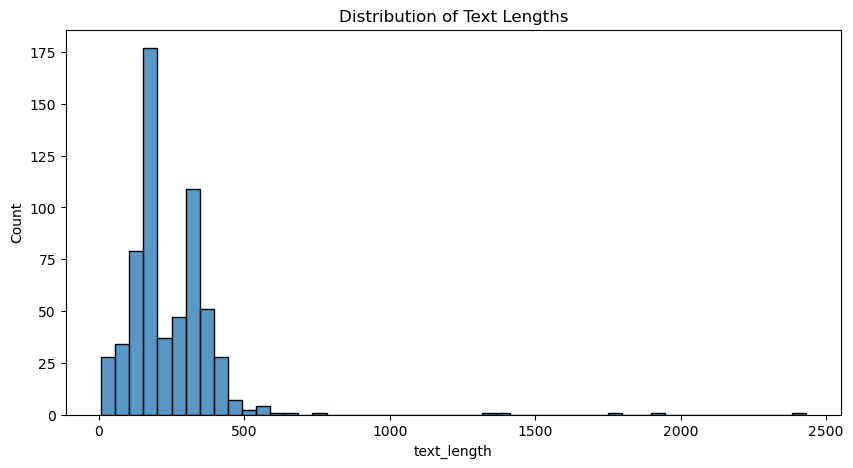

In [24]:
data['text_length'] = data['description'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(data['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.show()

## **Section C: Data Pre-Processing** 
- After examining the data, we now will conduct standard pre-processing of the data. The pre-processing steps include: 
1. removing of stopwords
2. removing special characters in word
3. tokenizing the word
4. lemmatize the word as well

In [26]:
lemma=WordNetLemmatizer() #lemmatization
stopwordss=stopwords.words('english') #list of stopwords

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s\s+',' ', text)
    words=word_tokenize(text)
    text=[]
    for word in words: 
        if word not in stopwordss: 
            normalized = lemma.lemmatize(word)
            text.append(normalized)
    return ' '.join(text)

In [27]:
# Apply preprocessing
data['cleaned_text'] = data['description'].apply(lambda x: preprocess_text(x))
data.head()

,description,species,text_length,cleaned_text
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna,162,jun javan myna share similarity common myna te...
1,Click here for more information about the Red ...,Collared Kingfisher,398,click information red list category criterion ...
2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole,349,black headed oriole oriolus larvatus specie bi...
3,"Search from thousands of royalty-free ""Javan M...",Javan Myna,177,search thousand royalty free javan myna stock ...
4,521 foreground recordings and 156 background ...,Little Egret,112,foreground recording background recording egre...


### **Further Pre-Processing: Chunking** 
Chunking is used to group the words into phrases based on their grammatical structures. This can be done through different ways which will be explored in this section.    
This section explores and conducts chunking through the use of the ```MWE Tokenizer```.    

#### *Usage of MWE Tokenizer*
Firstly, the MWE tokenizer is used to tokenize the words that are known to bee together, such as those words that are related to the labels.

In [29]:
#multi-class
mw=[('black','headed'),('black','headed','oriole'), ('black','naped', 'oriole'),('black','oriole'),('javan', 'myna'), ('little', 'egret')]

# Create a reference variable for Class MWETokenizer 
tk = MWETokenizer(mw) 

def using_mwe(x):
    txt=[]
    texts = tk.tokenize(x.split(' '))
    for text in texts: 
        txt.append(text)
    return ' '.join(txt)

# Use tokenize method 
data['chunked']=data['cleaned_text'].apply(using_mwe)

In [30]:
data['chunked']

0      jun javan_myna share similarity common myna te...
1      click information red list category criterion ...
2      black_headed_oriole oriolus larvatus specie bi...
3      search thousand royalty free javan_myna stock ...
4      foreground recording background recording egre...
                             ...                        
735    black_naped_oriole oriolus chinensis black_nap...
736    feb sacred kingfisher todiramphus sanctus leng...
737    august historical record show little_egret egr...
738    file black_naped_oriole oriolus chinensis chin...
739    larger cattle egret black leg yellow slipper b...
Name: chunked, Length: 611, dtype: object

These words can now be removed from the text, as it may cause biasedness in the dataset

In [32]:
def remove_mwe_tokens(tokens): 
    txt=[]
    texts = tokens.split(' ')
    for text in texts: 
        if '_' not in text:
            txt.append(text)
    return ' '.join(txt)

data['chunked']=data['chunked'].apply(lambda x:remove_mwe_tokens(x))

data['chunked'].head()

0    jun share similarity common myna term physical...
1    click information red list category criterion ...
2    oriolus larvatus specie bird family oriolidae ...
3    search thousand royalty free stock image video...
4    foreground recording background recording egre...
Name: chunked, dtype: object

[('oriolus', 'JJ'), ('larvatus', 'NN'), ('specie', 'NN'), ('bird', 'VBD'), ('family', 'NN'), ('oriolidae', 'NN'), ('found', 'VBD'), ('africa', 'RB'), ('striking', 'JJ'), ('appearance', 'NN'), ('bright', 'VBD'), ('yellow', 'JJ'), ('body', 'NN'), ('contrasting', 'VBG'), ('black', 'JJ'), ('head', 'NN'), ('flesh', 'NN'), ('coloured', 'VBD'), ('beak', 'JJ'), ('taxonomy', 'NN'), ('systematics', 'NNS'), ('edit', 'VBP'), ('authority', 'NN'), ('considered', 'VBN'), ('mountain', 'NN'), ('oriole', 'JJ'), ('subspecies', 'NNS')]

In one of the POS Tags as per above, to get the bird's physical characteristics 'striking_appearance', 'bright yellow body', are all helpful to the analysis, and can be structured likewise to be chunked together, such that it can be interpreted as the same meaning. 

### **After Pre-Processing**: Further steps - Examining Text Length
- From initial observations of the dataset, there are some rather short sentences after cleaning which can be removed. Th
Examining Text Length. As a generalised rule, I want to print out the texts which are less than 25 words.

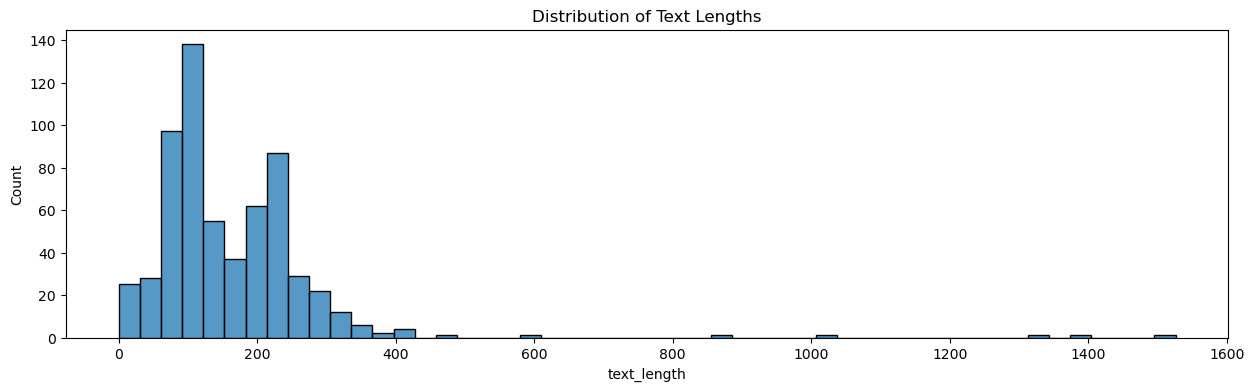

In [35]:
data['text_length'] = data['chunked'].apply(len)
plt.figure(figsize=(15,4))
sns.histplot(data['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.show()

In [36]:
sentences=[]
def txtlen(text): 
    if len(text) < 25: 
        sentences.append(text)

data['chunked'].apply(lambda x:txtlen(x))
print(sentences)

['published august', 'px captcha', 'published august view k', 'article', 'two four five sound make', '', 'common myna common', 'specie', 'published september view', 'crunchy crunchy', 'article', 'may hunting morning', 'april fool joke', 'taken elmley', 'published august', 'two four five sound make', 'published july view', 'specie bird', 'domain may sale', 'specie bird', 'video sound frequency']


As we can see, for those where the text length are less than 50. These are often rather irrelevant data, hence its more pertinent to remove them. And hence they are removed. 

In [38]:
def removetxt(text): 
    if len(text) < 25: 
        return np.NaN
    else: 
        return text
data['chunked']=data['chunked'].apply(lambda x:removetxt(x))

In [39]:
data.isnull().sum()

description      0
species          0
text_length      0
cleaned_text     0
chunked         21
dtype: int64

In [40]:
data.dropna(inplace=True)

data.info()

## **Section D: After Data Cleaning** 

We can now say that the data cleaning and pre-processing processes are completed. Now, only the column 'chunked' which contains the final cleaned data and 'species' which contain the target variable is extracted. 

In [43]:
cleaned = data[['chunked', 'species']]
cleaned.rename(columns={'chunked':'cleaned'}, inplace=True)

/var/folders/53/1_08_22s37n3r4dm51m_8m7c0000gn/T/ipykernel_21995/2080211542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.rename(columns={'chunked':'cleaned'}, inplace=True)


In [44]:
cleaned.head()

,cleaned,species
0,jun share similarity common myna term physical...,Javan Myna
1,click information red list category criterion ...,Collared Kingfisher
2,oriolus larvatus specie bird family oriolidae ...,Black-naped Oriole
3,search thousand royalty free stock image video...,Javan Myna
4,foreground recording background recording egre...,Little Egret


In [45]:
#ORIGINAL DATASET
original=pd.read_excel('Data.xlsx').head()
original.head()

,description,species
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna
1,Click here for more information about the Red ...,Collared Kingfisher
2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole
3,"Search from thousands of royalty-free ""Javan M...",Javan Myna
4,521 foreground recordings and 156 background ...,Little Egret


When comparing between the cleaned dataset and the original dataset, there are vast differences between the 'cleaned' column and the 'description' column. We can firstly see that there are no more numbers, and there are some special characters such as 'ï¿½ 'which are removed as a result of pre-processing. This has also made it much easier for modelling purposes in part 2.

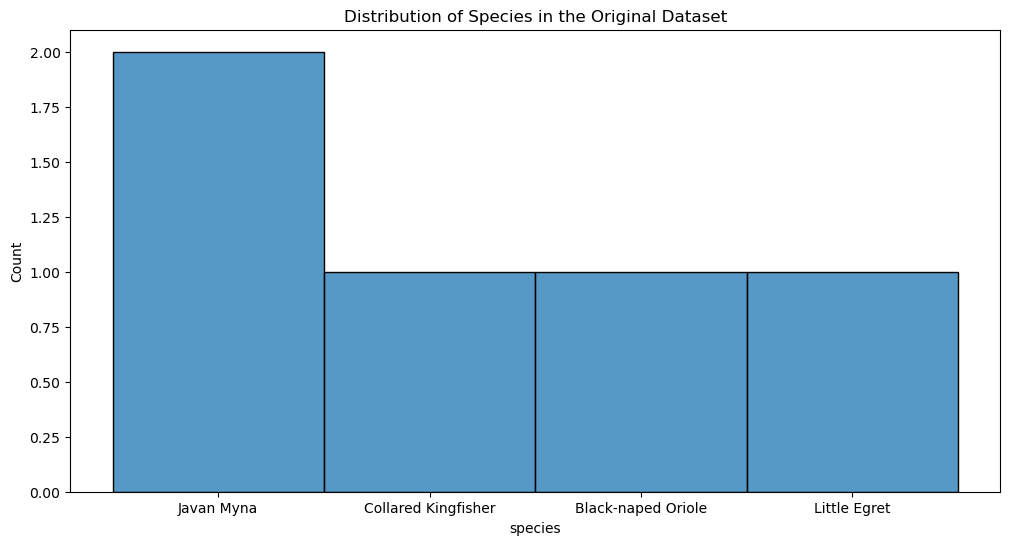

In [47]:
group=original.groupby(['species']).count()
plt.figure(figsize=(12, 6))  
sns.histplot(original['species'])
plt.title('Distribution of Species in the Original Dataset')
plt.show()

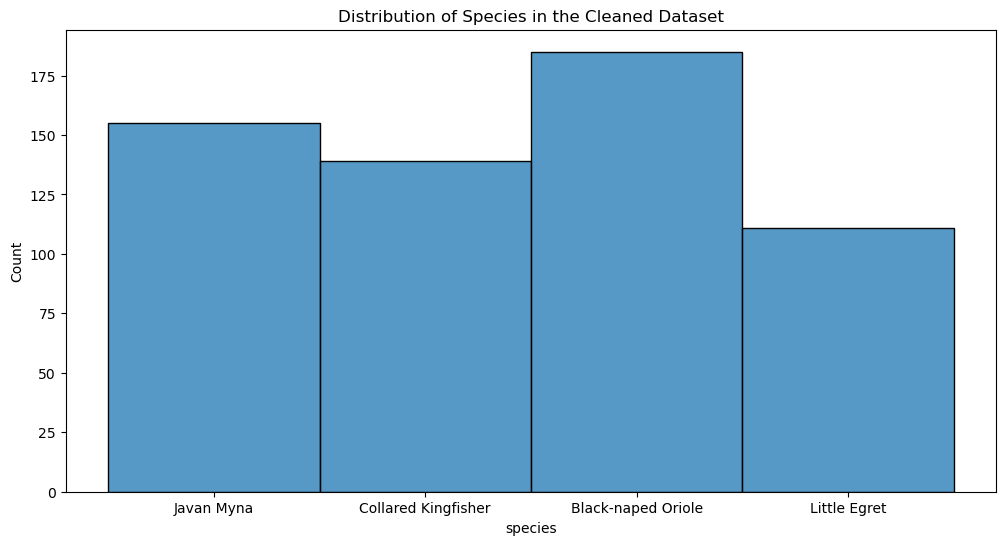

In [48]:
group=cleaned.groupby(['species']).count()
plt.figure(figsize=(12, 6))  
sns.histplot(cleaned['species'])
plt.title('Distribution of Species in the Cleaned Dataset')
plt.show()

Ignoring the axis for the distribution in the original dataset, which is rather inaccurate due to the null and duplicates not being removed ye, we can observe, that initially the dataset was just skewed towards the javan myna. Now, after the data cleaning, we can observe that the little egret is rather undersampled. However, it has become more adequately balanced as well, which is a good thing. These minor imbalances can be solved with using models that caters to these imbalances such as Naive Bayes. 

## **Saving the Data and Tokenizer**

In [51]:
cleaned.to_csv('cleaned_data.csv')

In [52]:
with open(f'MWE Tokenizer.pkl', 'wb') as f1: 
    pickle.dump(tk, f1)